# 预测波士顿房价

## 在 SageMaker 中使用 XGBoost（部署）

_机器学习工程师纳米学位课程 | 部署_

---

为了介绍 SageMaker 的高阶 Python API，我们将查看一个相对简单的问题。我们将使用[波士顿房价数据集](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)预测波士顿地区的房价中位数。

高阶 API 的文档位于 [ReadTheDocs 页面](http://sagemaker.readthedocs.io/en/latest/)

## 一般步骤

通常，在 notebook 实例中使用 SageMaker 时，你需要完成以下步骤。当然，并非每个项目都要完成每一步。此外，有很多步骤有很大的变化余地，你将在这些课程中发现这一点。

1. 下载或检索数据。
2. 处理/准备数据。
3. 将处理的数据上传到 S3。
4. 训练所选的模型。
5. 测试训练的模型（通常使用批转换作业）。
6. 部署训练的模型。
7. 使用部署的模型。

在此 notebook 中，我们将跳过第 5 步 - 测试模型。我们依然会测试模型，但是首先会部署模型，然后将测试数据发送给部署的模型。

## 第 0 步：设置 notebook

先进行必要的设置以运行 notebook。首先，加载所需的所有 Python 模块。

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

除了上面的模块之外，我们还需要导入将使用的各种 SageMaker 模块。

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## 第 1 步：下载数据

幸运的是，我们可以使用 sklearn 检索数据集，所以这一步相对比较简单。

In [3]:
boston = load_boston()

## 第 2 步：准备和拆分数据

因为使用的是整洁的表格数据，所以不需要进行任何处理。但是，我们需要将数据集中的各行拆分成训练集、测试集和验证集。

In [4]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## 第 3 步：将训练和验证文件上传到 S3

使用 SageMaker 创建训练作业后，进行训练操作的容器会执行。此容器可以访问存储在 S3 上的数据。所以我们需要将用来训练的数据上传到 S3。我们可以使用 SageMaker API 完成这一步，它会在后台自动处理一些步骤。

### 将数据保存到本地

首先，我们需要创建训练和验证 csv 文件，并将这些文件上传到 S3。

In [5]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
# We use pandas to save our train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, it is assumed
# that the first entry in each row is the target variable.

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### 上传到 S3

因为目前正在 SageMaker 会话中运行，所以可以使用代表此会话的对象将数据上传到默认的 S3 存储桶中。注意，建议提供自定义 prefix（即 S3 文件夹），以防意外地破坏了其他 notebook 或项目上传的数据。

In [7]:
prefix = 'boston-xgboost-deploy-hl'

val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## 第 4 步：训练 XGBoost 模型

将训练和验证数据上传到 S3 后，我们可以构建 XGBoost 模型并训练它了。我们将使用高阶 SageMaker API 完成这一步，这样的话代码更容易读懂，但是灵活性较差。

为了构建一个评估器（即我们要训练的对象），我们需要提供训练代码所在的容器的位置。因为我们使用的是内置算法，所以这个容器由 Amazon 提供。但是，容器的完整名称比较长，取决于我们运行所在的区域。幸运的是，SageMaker 提供了一个实用方法，叫做 `get_image_uri`，它可以为我们构建镜像名称。

为了使用 `get_image_uri` 方法，我们需要向其提供当前所在区域（可以从 session 对象中获得），以及要使用的算法的名称。在此 notebook 中，我们将使用 XGBoost，但是你也可以尝试其他算法。[常见参数](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html)中列出了 Amazon 的内置算法。

In [11]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

	get_image_uri(region, 'xgboost', '0.90-1').


在要求 SageMaker 开始训练作业之前，我们需要设置模型超参数。如果使用 XGBoost 算法，可以设置的超参数有很多，以下只是其中几个。如果你想修改下面的超参数或修改其他超参数，请参阅 [XGBoost 超参数页面](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)

In [12]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

完全设置好 estimator 对象后，可以训练它了。我们需要告诉 SageMaker 输入数据是 csv 格式，然后调用 `fit` 方法。

In [13]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-03-26 11:55:28 Starting - Starting the training job...
2020-03-26 11:55:29 Starting - Launching requested ML instances......
2020-03-26 11:56:30 Starting - Preparing the instances for training......
2020-03-26 11:57:48 Downloading - Downloading input data
2020-03-26 11:57:48 Training - Downloading the training image..Arguments: train
[2020-03-26:11:58:08:INFO] Running standalone xgboost training.
[2020-03-26:11:58:08:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8503.11mb
[2020-03-26:11:58:08:INFO] Determined delimiter of CSV input is ','
[11:58:08] S3DistributionType set as FullyReplicated
[11:58:08] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-03-26:11:58:08:INFO] Determined delimiter of CSV input is ','
[11:58:08] S3DistributionType set as FullyReplicated
[11:58:08] 112x13 matrix with 1456 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&


2020-03-26 11:58:21 Uploading - Uploading generated training model
2020-03-26 11:58:21 Completed - Training job completed
Training seconds: 49
Billable seconds: 49


## 第 5 步：测试模型

暂时我们将跳过这一步。我们依然会测试训练过的模型，但是我们将使用部署的模型，而不是设置批转换作业。


## 第 6 步：部署训练过的模型

将模型拟合训练数据并使用验证数据避免过拟合后，我们可以部署和测试模型了。使用高阶 API 部署模型很简单，我们只需对训练的评估器调用 `deploy` 方法。

**注意：**部署模型是指要求 SageMaker 启动一个计算实例，它将等待接收数据。因此，此计算实例将一直运行，直到你关闭它。这一点很重要，因为部署的端点按照运行时长计费。

也就是说，**如果你不再使用部署的端点，请关闭！**

In [14]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-------------!

## 第 7 步：使用模型

现在模型已经训练和部署，我们可以向其发送数据并评估结果。因为我们的测试数据集很小，所以调用一次端点就可以发送了。如果测试数据集很大，我们需要拆分数据并分批发送，然后合并结果。

In [15]:
# We need to tell the endpoint what format the data we are sending is in
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

Y_pred = xgb_predictor.predict(X_test.values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
Y_pred = np.fromstring(Y_pred, sep=',')

为了查看模型的运行效果，我们可以绘制一个简单的预测值与真实值散点图。如果模型的预测完全准确的话，那么散点图将是一条直线 $x=y$。可以看出，我们的模型表现不错，但是还有改进的余地。

Text(0.5, 1.0, 'Median Price vs Predicted Price')

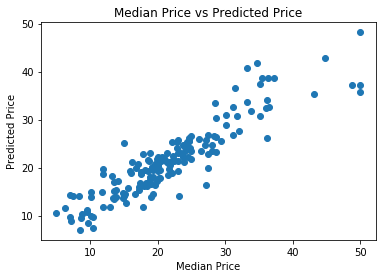

In [16]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## 删除端点

因为我们不再使用部署的端点，所以需要关闭端点。注意，部署的端点按照运行时长计费，所以运行越久，费用越多。

In [17]:
xgb_predictor.delete_endpoint()

## 可选步骤：清理数据

SageMaker 上的默认 notebook 实例没有太多的可用磁盘空间。当你继续完成和执行 notebook 时，最终会耗尽磁盘空间，导致难以诊断的错误。完全使用完 notebook 后，建议删除创建的文件。你可以从终端或 notebook hub 删除文件。以下单元格中包含了从 notebook 内清理文件的命令。

In [18]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir